## Script summary 
This script takes satellite data (sst, chl-a, pc and sss) and bins them by lat/lon to yield average values of each parameter for each grid cell. These values will then be used to model Nfix rates for each cell.

The script is organized as follows:

1) Data are imported.

2) Data are transformed.

3) Data are binned and output to a new file.

*Note:  Salinity data are excluded from this version of the script as these data are at very low resolution and ultimately do not improve model performance.*

In [1]:
# This script was written using Python 3.7

# for general use...
import pandas as pd # written using v. 0.24.2
import numpy as np # written using v. 1.16.2

# for calculations...
import math # written using v. 1.1.0
import scipy.stats as ss # written using v. 1.3.2
import gsw # written using v. 3.3.1

# for data visualization...
import matplotlib.pyplot as plt # written using v. 3.1.1
import cmocean # written using v. 2.0
import string

# for creating maps...
import cartopy as cp # written using v. 0.17.0
import cartopy.crs as ccrs # CRS holds the various projections
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io import shapereader

# to read netCDF data...
import netCDF4 as nc # written using v. 1.4.2
from netCDF4 import Dataset as NetCDFFile

# to save final figures as .tiff...
from PIL import Image # written using v. 7.0.0
import io

## 1) Data are imported.

In [149]:
# sst data from https://oceandata.sci.gsfc.nasa.gov; accessed 2020-3-19
# units:  degrees Celsius

# CITATION: NASA Goddard Space Flight Center, O.B.P.G. (2018 Reprocessing) Moderate-resolution Imaging Spectroradiometer 
# (MODIS) Aqua Chlorophyll Data. NASA Ocean Biology Distibuted Active Archive Center (OB.DAAC), Goddard Space Flight Center,
# Greenbelt, MD. https://oceancolor.gsfc.nasa.gov/

infile = '../Data/AQUA_MODIS.20160812_20160819.L3m.8D.SST.x_sst.nc'
df_tsat = nc.Dataset(infile)
tlat = df_tsat.variables['lat'][:]
tlon = df_tsat.variables['lon'][:]
tsat = df_tsat.variables['sst'][:]

df_tsat.close()

In [150]:
print("Lon shape: %i" % tlon.shape)
print("Lat shape: %i" % tlat.shape)
print("Var shape:")
print(tsat.shape)

Lon shape: 240
Lat shape: 240
Var shape:
(240, 240)


In [151]:
# chl data from https://oceandata.sci.gsfc.nasa.gov; accessed 2020-3-19
# units:  mg m^-3

# CITATION: NASA Goddard Space Flight Center, O.B.P.G. (2018 Reprocessing) Moderate-resolution Imaging Spectroradiometer 
# (MODIS) Aqua Chlorophyll Data. NASA Ocean Biology Distibuted Active Archive Center (OB.DAAC), Goddard Space Flight Center,
# Greenbelt, MD. https://oceancolor.gsfc.nasa.gov/

infile = '../Data/AQUA_MODIS20160812_20160819_L3m_8D_CHL.x_chlor_a.nc'
df_csat = nc.Dataset(infile)
clat = df_csat.variables['lat'][:]
clon = df_csat.variables['lon'][:]
csat = df_csat.variables['chlor_a'][:]

df_csat.close()
logcsat = np.log10(csat)

C:\Users\corda\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


In [152]:
print("Lon shape: %i" % clon.shape)
print("Lat shape: %i" % clat.shape)
print("Var shape:")
print(csat.shape)

Lon shape: 480
Lat shape: 288
Var shape:
(288, 480)


In [153]:
# pic data from https://oceandata.sci.gsfc.nasa.gov; accessed 2020-3-24
# units: mol m^-3 = mM

# CITATION: NASA Goddard Space Flight Center, O.B.P.G. (2018 Reprocessing) Moderate-resolution Imaging Spectroradiometer 
# (MODIS) Aqua Chlorophyll Data. NASA Ocean Biology Distibuted Active Archive Center (OB.DAAC), Goddard Space Flight Center,
# Greenbelt, MD. https://oceancolor.gsfc.nasa.gov/

infile = '../Data/A20162252016232.L3m_8D_PIC.x_pic.nc'
pic_df = nc.Dataset(infile)
piclat = pic_df.variables['lat'][:]
piclon = pic_df.variables['lon'][:]
pic = pic_df.variables['pic'][:]

pic_df.close()

pic.shape

(240, 240)

In [154]:
# poc data from https://oceandata.sci.gsfc.nasa.gov; accessed 2020-3-24
# units:  mg m^-3

# CITATION: NASA Goddard Space Flight Center, O.B.P.G. (2018 Reprocessing) Moderate-resolution Imaging Spectroradiometer 
# (MODIS) Aqua Chlorophyll Data. NASA Ocean Biology Distibuted Active Archive Center (OB.DAAC), Goddard Space Flight Center,
# Greenbelt, MD. https://oceancolor.gsfc.nasa.gov/

infile = '../Data/A20162252016232.L3m_8D_POC.x_poc.nc'
poc_df = nc.Dataset(infile)
poclat = poc_df.variables['lat'][:]
poclon = poc_df.variables['lon'][:]
poc = poc_df.variables['poc'][:]

poc_df.close()

poc.shape

(240, 240)

In [155]:
# Total particulate carbon was measured on-board. Here I calculate it from MODIS PIC and POC concentrations.

# Standardize units
poc_uM = poc/(12.011) # 1 mmol C = 12.011 mg C; 1 m^3 = 1000 L
pic_uM = pic*1000

pcsat = poc_uM + pic_uM
logpcsat = np.log10(pcsat)

C:\Users\corda\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


In [156]:
print("Lon shape: %i" % piclon.shape)
print("Lat shape: %i" % piclat.shape)
print("Var shape:")
print(pcsat.shape)

Lon shape: 240
Lat shape: 240
Var shape:
(240, 240)


In [157]:
# sal data from https://podaac-tools.jpl.nasa.gov/drive/files/allData/smap/L3/JPL/V4.3/8day_running/2016/224; accessed 2020-3-27
# units: psu

# CITATION:  Fore, A., S. Yueh, W. Tanh, A. Hayashi, 2020:  JPL SMAP Ocean Surface Salinity Products [Level 2B, 
# Level 3 Running 8-day, Level 3 Monthly], Version 4.3 validated release. Jet Propulsion Laboratory, Pasadena, CA, USA.

infile = '../Data/SMAP_L3_SSS_20160815_8DAYS_V4.3.nc'
df_ssat = nc.Dataset(infile)
ssat = df_ssat.variables['smap_sss'][:]
slat = df_ssat.variables['latitude'][:]
slon = df_ssat.variables['longitude'][:]

df_ssat.close()

In [158]:
print("Lon shape: %i" % slon.shape)
print("Lat shape: %i" % slat.shape)
print("Var shape:")
print(ssat.shape)

Lon shape: 1440
Lat shape: 720
Var shape:
(720, 1440)


In [159]:
# elevation data from https://maps.ngdc.noaa.gov/viewers/wcs-client; accessed 2020-03-19
# units:  m

# CITATION: Amante, C. and B.W. Eakins, 2009. ETOPO1 1 Arc-Minute Global Relief Model: Procedures, Data Sources and Analysis. 
# NOAA Technical Memorandum NESDIS NGDC-24. National Geophysical Data Center, NOAA. doi:10.7289/V5C8276M [2020-03-19].

infile = 'C:/Users/corda/Dropbox/Resources/etopo1_bedrock_eastNAmericanshelf_20200119.nc'
bathy_df = nc.Dataset(infile)
blat = bathy_df.variables['lat'][:]
blon = bathy_df.variables['lon'][:]
bathy = bathy_df.variables['Band1'][:]

bathy_df.close()

In [160]:
print("Lon shape: %i" % blon.shape)
print("Lat shape: %i" % blat.shape)
print("Var shape:")
print(bathy.shape)

Lon shape: 1515
Lat shape: 1551
Var shape:
(1551, 1515)


## 2) Data are transformed.
The satellite data are currently n-dimensional arrays. In order to bin these data, we need matrices with lat, lon and a single value for each measurement.

In [161]:
# This function transforms the n-dimensional satellite data array into a matrix with lat, lon and the data value
# The following must be defined:
# array - the satellite data array to be transformed
# xlat - the list of latitudes corresponding to the array
# xlon - the list of longitudes corresponding to the array
# OutFileName - the name of the .csv file that will be produced (e.g. "chlorophyll.csv")

def transform():
    OutFile = open(OutFileName, 'w')

    # Write header line to new file
    OutFile.write("lat,lon,value\n")

    length = len(xlat)
    width = len(xlon)

    length_list = np.arange(0,length,1)
    width_list = np.arange(0,width,1)

    for i in length_list:
        row = array[i:i+1]
        lat = xlat[i:i+1]
        for j in width_list:
            value = (row[:,j:j+1])
            lon = xlon[j:j+1]
            OutputString = "%f,%f,%f" % (lat,lon,value)
            OutFile.write(OutputString + "\n")

    OutFile.close()

In [162]:
# TEMPERATURE
# Define data to be transformed and output file name
array = tsat
xlat = tlat
xlon = tlon
OutFileName = "../Calculations/MODIS_8daymean_2016Aug12to19_temp_C.csv"

transform()

C:\Users\corda\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Warning: converting a masked element to nan.


In [163]:
# CHLOROPHYLL A
# Define data to be transformed and output file name
array = csat
xlat = clat
xlon = clon
OutFileName = "../Calculations/MODIS_8daymean_2016Aug12to19_chl_mgm3.csv"

transform()

C:\Users\corda\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Warning: converting a masked element to nan.


In [164]:
# PARTICULATE C
# Define data to be transformed and output file name
array = pcsat
xlat = piclat
xlon = piclon
OutFileName = "../Calculations/MODIS_8daymean_2016Aug12to19_pc_uM.csv"

transform()

C:\Users\corda\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Warning: converting a masked element to nan.


In [165]:
# # SALINITY
# # Define data to be transformed and output file name
# array = ssat
# xlat = slat
# xlon = slon
# OutFileName = "../Calculations/SMAP_8daymean_2016Aug12to19_sal_psu.csv"

# transform()

In [166]:
# BATHYMETRY
# Define data to be transformed and output file name
array = bathy
xlat = blat
xlon = blon
OutFileName = "../Calculations/ETOPO1_elevation_m.csv"

transform()

## 3) Data are binned and output to a new file.
i.e., binned on the same grid at the same resolution at the same resolution

Text(0, 0.5, 'Latitude ($\\degree$N)')

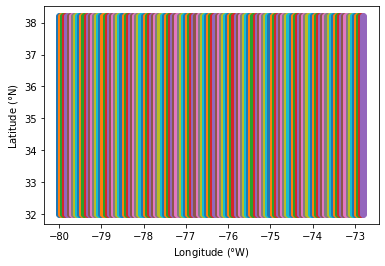

In [3]:
# need to bin the data into a grid to contour it

# make a grid
x = np.arange(-80, -72.75, 0.05)
y = np.arange(32, 38.25, 0.05)

xx, yy = np.meshgrid(x, y)

h = plt.plot(xx, yy, 'o')
plt.xlabel("Longitude ($\degree$W)")
plt.ylabel("Latitude ($\degree$N)")

In [4]:
# TEMPERATURE
# bin the data into the grid

infile = "../Calculations/MODIS_8daymean_2016Aug12to19_temp_C.csv"
df = pd.read_csv(infile)

binned_t = ss.binned_statistic_2d(df.lon, df.lat, df.value, statistic='mean', bins=[x, y])

In [5]:
# CHLOROPHYLL A
# bin the data into the grid

infile = "../Calculations/MODIS_8daymean_2016Aug12to19_chl_mgm3.csv"
df = pd.read_csv(infile)

binned_chl = ss.binned_statistic_2d(df.lon, df.lat, df.value, statistic='mean', bins=[x, y])

In [6]:
# PARTICULATE C
# bin the data into the grid

infile = "../Calculations/MODIS_8daymean_2016Aug12to19_pc_uM.csv"
df = pd.read_csv(infile)

binned_pc = ss.binned_statistic_2d(df.lon, df.lat, df.value, statistic='mean', bins=[x, y])

In [7]:
# # SALINITY
# # bin the data into the grid

# infile = "../Calculations/SMAP_8daymean_2016Aug12to19_sal_psu.csv"
# df = pd.read_csv(infile)

# binned_s = ss.binned_statistic_2d(df.lon, df.lat, df.value, statistic='mean', bins=[x, y])

In [8]:
# ELEVATION
# bin the data into the grid

infile = "../Calculations/ETOPO1_elevation_m.csv"
df = pd.read_csv(infile)

binned_b = ss.binned_statistic_2d(df.lon, df.lat, df.value, statistic='mean', bins=[x, y])

Text(0, 0.5, 'Latitude ($\\degree$N)')

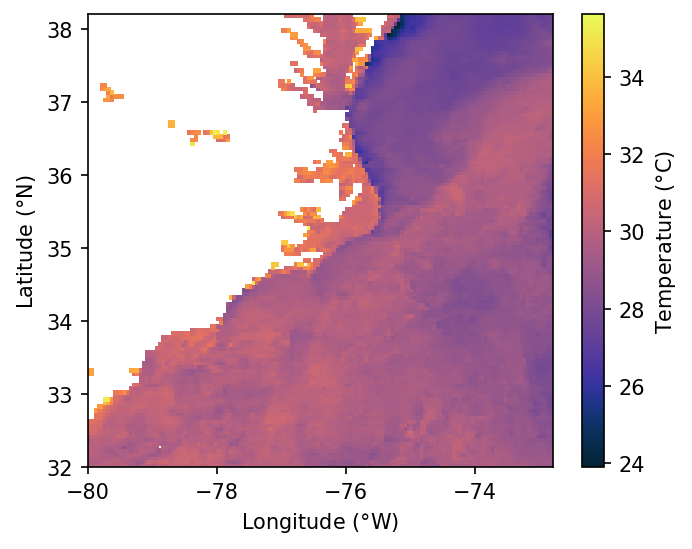

In [182]:
# plot the binned data to ensure everything looks good

XX, YY = np.meshgrid(binned_t.x_edge, binned_t.y_edge)

fig, ax = plt.subplots(1,1, figsize = (5,4), dpi = 150)

palette = 'cmo.thermal'
plt.pcolormesh(XX, YY, binned_t.statistic.T, cmap = palette)
cb = plt.colorbar()

cb.set_label("Temperature ($\degree$C)")
plt.xlabel("Longitude ($\degree$W)")
plt.ylabel("Latitude ($\degree$N)")

In [9]:
# Save the binned data to a .csv file

# Make a new file
OutFileName = "../Calculations/compiledseasfcdata_8daymean_2016Aug12to19_onetwentiethdegreegrid.csv"
OutFile = open(OutFileName, 'w')

# Write header line to new file
OutFile.write("Lat,Lon,EstDepth_m,SeafloorDepth_m,Temp_c,Chl_mgm3,PCconc_uM\n")

# Get an x,y coordinate for the center of each cell
xlon = (x[:-1] + x[1:]) / 2
xlat = (y[:-1] + y[1:]) / 2

# Call n-dimensional arrays of mean values for the given grid
# s = binned_s.statistic.T
t = binned_t.statistic.T
pc = binned_pc.statistic.T
chl = binned_chl.statistic.T
b = binned_b.statistic.T

# Define lists to loop through of the correct size
length = len(xlat)
width = len(xlon)
length_list = np.arange(0,length,1)
width_list = np.arange(0,width,1)

for i in length_list:
    
#     row_s = s[i:i+1]
    row_t = t[i:i+1]
    row_pc = pc[i:i+1]
    row_chl = chl[i:i+1]
    row_b = b[i:i+1]
    lat = xlat[i:i+1]
    for j in width_list:
        depth = 2.5
#         value_s = (row_s[:,j:j+1])
        value_t = (row_t[:,j:j+1])
        value_pc = (row_pc[:,j:j+1])
        value_chl = (row_chl[:,j:j+1])
        value_b = (row_b[:,j:j+1])
        lon = xlon[j:j+1]
        OutputString = "%f,%f,%f,%f,%f,%f,%f" % (lat,lon,depth,value_b,value_t,value_chl,value_pc)
        OutFile.write(OutputString + "\n")

OutFile.close()

In [10]:
# check output file
a = pd.read_csv(OutFileName)
a.head()

,Lat,Lon,EstDepth_m,SeafloorDepth_m,Temp_c,Chl_mgm3,PCconc_uM
0,32.025,-79.975,2.5,-28.444444,29.724998,0.383358,8.274037
1,32.025,-79.925,2.5,-30.222222,29.760000,0.365913,8.190781
2,32.025,-79.875,2.5,-30.777778,29.907500,0.358353,8.129861
3,32.025,-79.825,2.5,-30.000000,30.019999,0.349471,7.992976
4,32.025,-79.775,2.5,-31.111111,30.054998,0.352093,8.028268
